# Datasets

> Datasets

In [ ]:
#| default_exp data.datasets

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import pandas as pd
import torchvision
import torch
from matplotlib import pyplot as plt
import torch.utils.data as data
from torchvision.utils import make_grid
from pytorch_lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from typing import Any, Dict, Optional, Tuple, List

## Vision

### ImageDataset base class

In [ ]:
#| export
class ImageDataset(Dataset):
    " Base class for image datasets providing visualization of (image, label) samples"

    def show_idx(self,
        index:int # Index of the (image,label) sample to visualize
        ):
        X, y = self.__getitem__(index)
        plt.figure(figsize = (1, 1))
        plt.imshow(X.numpy().reshape(28,28),cmap='gray')
        plt.title(f"Label: {int(y)}")
        plt.show()

    @staticmethod
    def show_grid(imgs, save_path=None):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            axs[0, i].imshow(img.numpy().reshape(28,28))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if save_path:
            plt.savefig(save_path)

    def show_random(self,
        n=3 # number of images to display
        ):
        indices = torch.randint(0,len(self), (n,))
        images = []
        for index in indices:
            X, y = self.__getitem__(index)
            X = X.reshape(28,28)
            images.append(X)
        self.show_grid(images)
        

### MNIST

#### MNIST dataset

In [ ]:
#| export 

class MNISTDataset(ImageDataset):
    "MNIST digit dataset"

    def __init__(
        self,
        data_dir:str='~/Data', # path where data is saved
        train = True, # train or test dataset
        transform:torchvision.transforms.transforms=torchvision.transforms.ToTensor() # data formatting
    ):

        super().__init__()

        self.ds = MNIST(
            data_dir,
            train = train,
            transform=transform, 
            download=True
        )

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        x = self.ds[idx][0]
        y = self.ds[idx][1]
        return x, y
    
    def train_dev_split(self,
        ratio:float, # percentage of train/dev split,
        seed:int=42 # rand generator seed
    ):
        train_set_size = int(len(self.ds) * ratio)
        valid_set_size = len(self.ds) - train_set_size

        # split the train set into two
        seed = torch.Generator().manual_seed(seed)
        train_set, valid_set = data.random_split(self.ds, [train_set_size, valid_set_size], generator=seed)
        return train_set, valid_set



Number of samples in the dataset: 10000
torch.Size([1, 28, 28]) 7 torch.FloatTensor


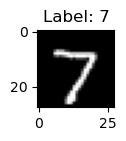

In [ ]:
ds = MNISTDataset('~/Data', train=False)
print(f"Number of samples in the dataset: {len(ds)}")
X, y = ds[0]
print(X.shape, y, X.type())
ds.show_idx(0)
train, dev = ds.train_dev_split(0.8)

#### MNIST DataModule

In [ ]:
#| export 

class MNISTDataModule(LightningDataModule):
    def __init__(
        self,
        data_dir: str = "~/Data/",
        train_val_test_split:List[float] = [0.8, 0.1, 0.1],
        batch_size: int = 64,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()
        self.save_hyperparameters(logger=False) # can access inputs with self.hparams
        self.transforms = transforms.Compose([transforms.ToTensor()])
        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None

        if sum(train_val_test_split) != 1.0:
            raise Exception('split percentages should sum up to 1.0')

    @property
    def num_classes(self):
        return 10

    def prepare_data(self):
        """Download data if needed + format with MNISTDataset
        """
        MNISTDataset(self.hparams.data_dir, train=True)
        MNISTDataset(self.hparams.data_dir, train=False)

    def setup(self, stage: Optional[str] = None):
        if not self.data_train and not self.data_val and not self.data_test:
            trainset = MNISTDataset(self.hparams.data_dir, train=True, transform=self.transforms)
            testset = MNISTDataset(self.hparams.data_dir, train=False, transform=self.transforms)
            dataset = ConcatDataset(datasets=[trainset, testset])
            lengths = [int(split * len(dataset)) for split in self.hparams.train_val_test_split]
            self.data_train, self.data_val, self.data_test = random_split(
                dataset=dataset,
                lengths=lengths,
                generator=torch.Generator().manual_seed(42),
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def teardown(self, stage: Optional[str] = None):
        """Clean up after fit or test."""
        pass

    def state_dict(self):
        """Extra things to save to checkpoint."""
        return {}

    def load_state_dict(self, state_dict: Dict[str, Any]):
        """Things to do when loading checkpoint."""
        pass


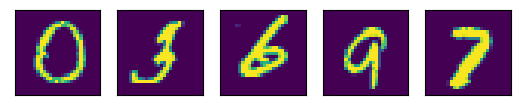

In [ ]:
dm = MNISTDataModule(
    data_dir="~/Data/",train_val_test_split=[0.8, 0.1, 0.1],
    batch_size = 64,
    num_workers = 0,
    pin_memory= False
)
dm.prepare_data()
dm.setup()
test_dl = dm.test_dataloader()
len(dm.data_test[0])
imgs = [dm.data_test[i][0] for i in range(5)]
ImageDataset.show_grid(imgs)

## Audio

In [ ]:
#| export
from lhotse.dataset import BucketingSampler
from lhotse.dataset.collation import TokenCollater
from lhotse.recipes import download_librispeech, prepare_librispeech
from lhotse.dataset.vis import plot_batch
from lhotse import CutSet
from lhotse import Fbank, FbankConfig
from lhotse.dataset import OnTheFlyFeatures
from pathlib import Path
from pprint import pprint

### Speech-To-Text

#### Base class

In [ ]:
#| export

class STTDataset(Dataset):
    def __init__(self,
        tokenizer:TokenCollater, # text tokenizer
        num_mel_bins:int=80 # number of mel spectrogram bins
        ):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=num_mel_bins)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "ilens": feat_lens, "tokens_pad": tokens}



#### LibriSpeech DataModule

In [ ]:
#| export
class LibriSpeechDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en", # where data will be saved / retrieved
        dataset_parts="mini_librispeech", # either full librispeech or mini subset
        output_dir="../recipes/stt/librispeech/data", # where to save manifest
        num_jobs=1 # num_jobs depending on number of cpus available
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def prepare_data(self,) -> None:
        download_librispeech(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        libri = prepare_librispeech(corpus_dir=Path(self.hparams.target_dir) / "LibriSpeech", output_dir=self.hparams.output_dir, num_jobs=self.hparams.num_jobs)
        self.cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
        self.cuts_test = CutSet.from_manifests(**libri["dev-clean-2"])
        self.tokenizer = TokenCollater(self.cuts_train)
        self.tokenizer(self.cuts_test.subset(first=2))
        self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=train_sampler, batch_size=None, num_workers=2)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=test_sampler, batch_size=None, num_workers=2)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

In [ ]:
dm = LibriSpeechDataModule(
    target_dir="/data/en", 
    dataset_parts="mini_librispeech",
    output_dir="../recipes/stt/librispeech/data",
    num_jobs=1
)

In [ ]:
# download
dm.prepare_data()

In [ ]:
dm.setup()

Dataset parts: 100%|██████████| 9/9 [03:04<00:00, 20.54s/it]


In [ ]:
from lhotse import RecordingSet
recs = RecordingSet.from_file("../recipes/stt/librispeech/data/librispeech_recordings_dev-clean-2.jsonl.gz")
len(recs)

1089

In [ ]:
from lhotse import SupervisionSet
sup = SupervisionSet("../recipes/stt/librispeech/data/librispeech_supervisions_dev-clean-2.jsonl.gz")
len(sup)

77

torch.Size([39, 1014, 80]) torch.Size([39, 178]) torch.Size([39])


<matplotlib.image.AxesImage>

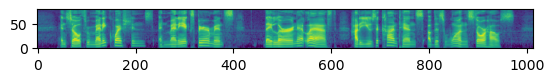

In [ ]:
test_dl = dm.test_dataloader()
b = next(iter(test_dl))
print(b["feats_pad"].shape, b["tokens_pad"].shape, b["ilens"].shape)
plt.imshow(b["feats_pad"][0].transpose(0,1), origin='lower')
# dm.tokenizer.idx2token(b["tokens_pad"][0])
# dm.tokenizer.inverse(b["tokens_pad"][0], b["ilens"][0])

In [ ]:
dm.cuts_test

CutSet(len=1089) [underlying data type: <class 'dict'>]

<AxesSubplot: >

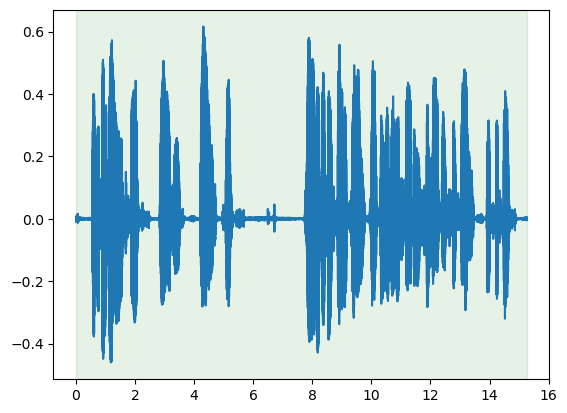

In [ ]:
cut = dm.cuts_train[0]
# pprint(cut.to_dict())
cut.plot_audio()

### Text-To-Speech

#### Base Class

In [ ]:
#| export
class TTSDataset(Dataset):
    def __init__(self,
        tokenizer:TokenCollater, # text tokenizer
        num_mel_bins:int=80 # number of mel spectrogram bins
        ):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=num_mel_bins)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "ilens": feat_lens, "tokens_pad": tokens}


#### LJSpeech DataModule

In [ ]:
#| export
class LJSpeechDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en", # where data will be saved / retrieved
        dataset_parts="mini_librispeech", # either full librispeech or mini subset
        output_dir="../recipes/tts/ljspeech/data" # where to save manifest
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def prepare_data(self,) -> None:
        download_librispeech(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        libri = prepare_librispeech(corpus_dir=Path(self.hparams.target_dir) / "LibriSpeech", output_dir=self.hparams.output_dir)
        self.cuts_train = CutSet.from_manifests(**libri["train-clean-5"])
        self.cuts_test = CutSet.from_manifests(**libri["dev-clean-2"])
        self.tokenizer = TokenCollater(self.cuts_train)
        self.tokenizer(self.cuts_test.subset(first=2))
        self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=train_sampler, batch_size=None, num_workers=2)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False, bucket_method="equal_duration")
        return DataLoader(STTDataset(self.tokenizer), sampler=test_sampler, batch_size=None, num_workers=2)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

#### LibriTTS DataModule

In [ ]:
#| export
from lhotse.recipes import download_libritts, prepare_libritts

/home/syl20/anaconda3/envs/nimrod/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export
class LibriTTSDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en/libriTTS", # where data will be saved / retrieved
        dataset_parts=["dev-clean", "test-clean"], # either full libritts or subset
        output_dir="/home/syl20/slg/nimrod/recipes/libritts/data" # where to save manifest
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def prepare_data(self,) -> None:
        # takes a while to download from openslr mirror (~15 min each for test/dev-clean)
        download_libritts(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        libri = prepare_libritts(corpus_dir=Path(self.hparams.target_dir) / "LibriTTS", output_dir=self.hparams.output_dir)
        self.cuts_train = CutSet.from_manifests(**libri["dev-clean"])
        self.cuts_test = CutSet.from_manifests(**libri["test-clean"])
        self.tokenizer = TokenCollater(self.cuts_train)
        self.tokenizer(self.cuts_test.subset(first=2))
        self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer), sampler=train_sampler, batch_size=None, num_workers=100)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer), sampler=test_sampler, batch_size=None, num_workers=2)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

In [ ]:
dm = LibriTTSDataModule()

In [ ]:
dm.prepare_data()

In [ ]:
dm.setup()

Scanning audio files (*.wav): 5736it [00:00, 15802.33it/s]it/s]
Scanning audio files (*.wav): 0it [00:00, ?it/s]00:00<00:05,  1.01it/s]
Scanning audio files (*.wav): 4837it [00:00, 14190.91it/s]
Scanning audio files (*.wav): 0it [00:00, ?it/s]00:01<00:02,  1.67it/s]
Scanning audio files (*.wav): 33236it [00:42, 774.33it/s]
Scanning audio files (*.wav): 116500it [02:28, 783.00it/s]5, 12.89s/it]
Scanning audio files (*.wav): 0it [00:00, ?it/s]03:42<00:55, 55.48s/it]
Preparing LibriTTS parts: 100%|██████████| 7/7 [03:42<00:00, 31.77s/it]


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()